In [ ]:
!pip install transformers

In [ ]:
!pip install nltk

In [ ]:
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Sentiment Analysis**
Sentiment dianalisa dan dijadikan kolom baru lalu disimpan dalam bentuk file csv

In [ ]:
import pandas as pd
import re
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Fungsi untuk membersihkan teks
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Hapus karakter non-alfanumerik
        text = re.sub(r'\s+', ' ', text).strip()    # Hapus whitespace ekstra
        return text.lower()
    return text

# Muat model dan tokenizer untuk analisis sentimen
pretrained = "mdhugol/indonesia-bert-sentiment-classification"
model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Fungsi untuk analisis sentimen
def analyze_sentiment(text):
    if isinstance(text, str) and text.strip():
        result = sentiment_analysis(text)
        label = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}[result[0]['label']]
        return label
    return None

# Muat data
#df = pd.read_csv('/content/manga_list.csv')
df = pd.read_csv('/content/manga_list_sentiment.csv')

# Lakukan pembersihan data pada kolom teks
df['Sinopsis'] = df['Sinopsis'].apply(clean_text)

# Terapkan analisis sentimen pada 100 data teratas
# df = df.head(10)
df['sentiment'] = df['Sinopsis'].apply(analyze_sentiment)

# Tampilkan hasil
df

,Title,Jenis,Genre,Status,Last Chapter Number,Sinopsis,Sentiment,sentiment
0,Cruise,Manhwa,"['Action', 'Drama', 'Horror', 'Seinen', 'Super...",Ongoing,28.0,pelayaran terbaik di korea mengundang tim yong...,negative,negative
1,Escort Warrior,Manhwa,"['Action', 'Historical', 'Military']",Ongoing,201.0,manhwa escort warrior yang dibuat oleh komikus...,neutral,neutral
2,It Starts With A Mountain,Manhua,"['Action', 'Adventure', 'Drama', 'Historical']",Ongoing,656.0,dimulai dengan satu pondok dan dua populasi ah...,negative,negative
3,I Work Nine To Five In The Immortal Cultivatio...,Manhua,"['Action', 'Comedy', 'Drama', 'Fantasy']",Ongoing,41.0,hua qingyuan meninggal secara tibatiba karena ...,positive,positive
4,The First Ancestor in History,Manhua,"['Action', 'Adventure', 'Fantasy', 'Martial Ar...",Ongoing,170.0,lin feng melakukan perjalanan antar dunia dan ...,negative,negative
...,...,...,...,...,...,...,...,...
5060,Nano List,Manhua,"['Action', 'Romance', 'Sci-fi', 'Tragedy']",Ongoing,146.0,manga isekai goumonhime bercerita tentang sete...,negative,negative
5061,Toppu GP,Manga,"['Drama', 'Seinen', 'Sport']",Ongoing,7.0,manga itoshi no karin bercerita tentang bertem...,positive,positive
5062,Hunter Age,Manga,"['Adventure', 'Comedy', 'Drama', 'Fantasy', 'R...",Ongoing,240.0,manga isekai cheat magician bercerita tentang ...,negative,negative
5063,Immortal Merchant,Manhwa,"['Adventure', 'Comedy', 'Fantasy', 'Isekai']",Ongoing,14.0,manga green worldz bercerita tentang tumbuhan ...,positive,positive


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


# **K-Means Clustering + Silhouette**
*   features: jenis, sentiment, status, last chapter number

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy import stats
import numpy as np

# Load data
#df_manga = pd.read_csv('/content/manga_list_sentiment_2.csv')
df_manga = pd.read_csv('/content/manga_list_sentiment.csv')

# Data cleaning
df_manga.dropna(subset=['Jenis', 'Genre', 'Status', 'Last Chapter Number', 'Sinopsis', 'Sentiment'], inplace=True)
df_manga['Last Chapter Number'] = pd.to_numeric(df_manga['Last Chapter Number'], errors='coerce')
df_manga.dropna(subset=['Last Chapter Number'], inplace=True)

# Duplicate 'Sentiment' column
df_manga['Sentiment_Duplicated'] = df_manga['Sentiment']

# Duplicate 'Genre' column
df_manga['Genre_Duplicated'] = df_manga['Genre']
df_manga['Genre_Duplicated_2'] = df_manga['Genre']

# Duplicate 'Jenis' column
df_manga['Jenis_Duplicated'] = df_manga['Jenis']

# Duplicate 'Status' column
df_manga['Status_Duplicated'] = df_manga['Status']

# Define a z-score threshold for outlier removal
z_score_threshold = 2

# Remove outliers for each numeric feature
numeric_features = ['Last Chapter Number']
for feature in numeric_features:
    z_scores = np.abs(stats.zscore(df_manga[feature]))
    df_manga = df_manga[(z_scores < z_score_threshold)]

# Split the data into training and testing sets
test_size = 0.25  # 25% for testing
random_state = 42  # for reproducibility
df_manga_train, df_manga_test = train_test_split(df_manga, test_size=test_size, random_state=random_state)

# Preprocessing
categorical_features = ['Jenis', 'Jenis_Duplicated', 'Sentiment', 'Sentiment_Duplicated', 'Status']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
text_features = 'Genre'
text_transformer = TfidfVectorizer()
numeric_features = ['Last Chapter Number']
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_features),
        ('num', numeric_transformer, numeric_features)
    ],
    transformer_weights={
        'cat': 4.0,  # You can adjust the weights as per your preference
        'text': 1,  # Lower weight for text_features
        'num': 0.5
    }
)

# Determine the number of clusters
n_clusters = min(df_manga_train.shape[0], 15)

# Pipeline for clustering
kmeans_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
])

# Fit the pipeline to the training data
kmeans_pipeline.fit(df_manga_train)

# Predict clusters for the training data
df_manga_train['Cluster'] = kmeans_pipeline.predict(df_manga_train)

# Display the training DataFrame with cluster labels
df_manga_train[['Title', 'Jenis', 'Status', 'Last Chapter Number', 'Sentiment', 'Cluster']]

# Silhouette Score Evaluation
# Transform training and testing features
train_features_transformed = preprocessor.transform(df_manga_train)
test_features_transformed = preprocessor.transform(df_manga_test)

# Silhouette score for training data
silhouette_avg_train = silhouette_score(train_features_transformed, df_manga_train['Cluster'])
print(f"Rata-rata Skor Siluet untuk data latih: {silhouette_avg_train:.2f}")

# Predict and evaluate for testing data
test_cluster_labels = kmeans_pipeline.named_steps['kmeans'].predict(test_features_transformed)
silhouette_avg_test = silhouette_score(test_features_transformed, test_cluster_labels)
print(f"Rata-rata Skor Siluet untuk data pengujian: {silhouette_avg_test:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Rata-rata Skor Siluet untuk data latih: 0.76
Rata-rata Skor Siluet untuk data pengujian: 0.76


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3723 samples in 0.001s...
[t-SNE] Computed neighbors for 3723 samples in 3.479s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3723
[t-SNE] Computed conditional probabilities for sample 2000 / 3723
[t-SNE] Computed conditional probabilities for sample 3000 / 3723
[t-SNE] Computed conditional probabilities for sample 3723 / 3723
[t-SNE] Mean sigma: 0.476119
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.357700
[t-SNE] KL divergence after 300 iterations: 1.677524


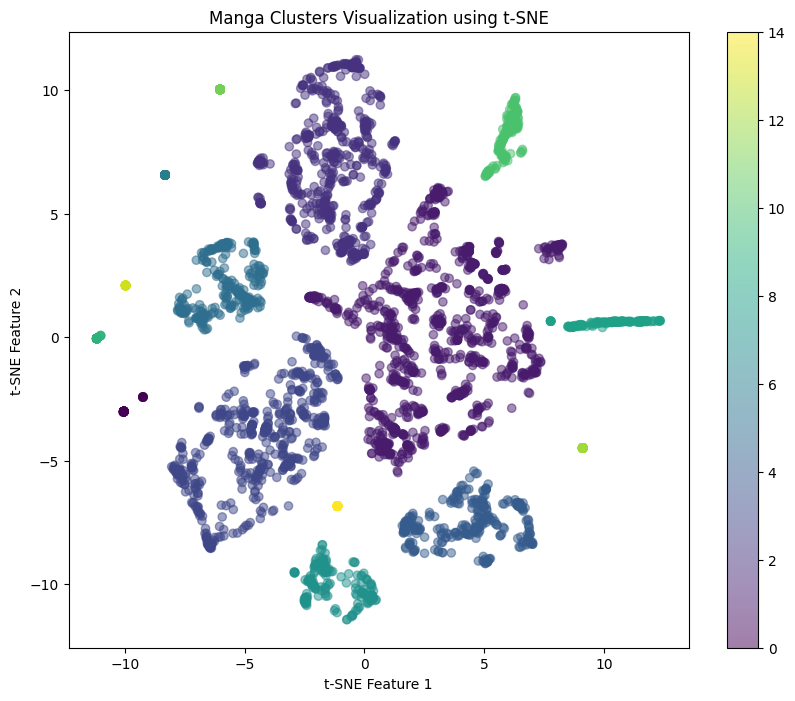

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNE for Dimensionality Reduction
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='random')
tsne_result = tsne.fit_transform(train_features_transformed)

# Scatter Plot for t-SNE Results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df_manga_train['Cluster'], cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('Manga Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3723 samples in 0.002s...
[t-SNE] Computed neighbors for 3723 samples in 3.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3723
[t-SNE] Computed conditional probabilities for sample 2000 / 3723
[t-SNE] Computed conditional probabilities for sample 3000 / 3723
[t-SNE] Computed conditional probabilities for sample 3723 / 3723
[t-SNE] Mean sigma: 0.476119
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.358875
[t-SNE] KL divergence after 300 iterations: 1.685289


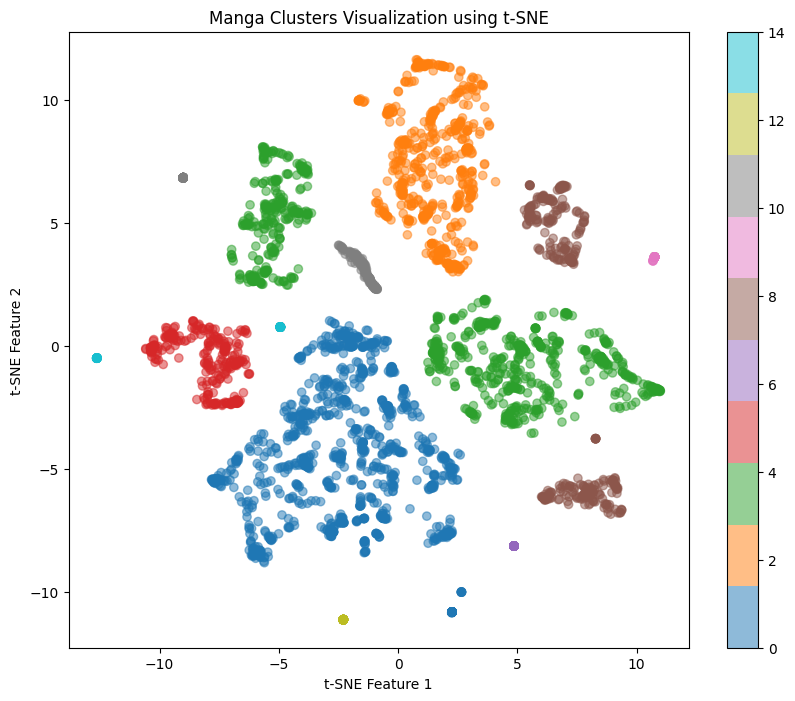

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Using t-SNE for dimensionality reduction with 'random' initialization
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='random')
tsne_result = tsne.fit_transform(train_features_transformed)

# Creating a scatter plot based on the t-SNE result
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df_manga_train['Cluster'], cmap='tab10', alpha=0.5)
plt.colorbar()
plt.title('Manga Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()


# **Visualisasi TF-IDF Genre**

In [ ]:
# Fit and transform the TF-IDF vectorizer on the entire dataset
tfidf_vectorizer = TfidfVectorizer()
df_manga_tfidf = tfidf_vectorizer.fit_transform(df_manga[text_features])

# Get feature names (terms) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to display the TF-IDF values with feature names
df_tfidf = pd.DataFrame(data=df_manga_tfidf.toarray(), columns=feature_names)

# Display the DataFrame with TF-IDF values
print("\nDataFrame with TF-IDF values for 'Genre':")
df_tfidf


DataFrame with TF-IDF values for 'Genre':


,actio,action,adaptation,adult,adventure,ai,aksi,arts,bender,comedy,...,system,thriller,tragedy,urban,vampire,vampires,villainess,workers,wuxia,yuri
0,0.0,0.254810,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.222935,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.441274,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.517343,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.305299,0.0,0.0,0.411248,0.0,0.0,0.567271,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.596072,0.0,0.0,0.802931,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959,0.0,0.214442,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.573535,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4960,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4961,0.0,0.000000,0.0,0.0,0.495727,0.0,0.0,0.000000,0.0,0.431453,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4962,0.0,0.000000,0.0,0.0,0.477928,0.0,0.0,0.000000,0.0,0.415962,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Hasil Clustering**

In [ ]:
# Group by cluster and calculate summary statistics
cluster_summary = df_manga_train.groupby('Cluster').agg({
    'Title': 'count',  # Count the number of titles in each cluster
    'Last Chapter Number': ['mean', 'min', 'max'],  # Average, min, and max of last chapter numbers
    'Genre': lambda x: x.mode()[0] if not x.mode().empty else 'No Mode',  # Most common genre in each cluster
    'Status': lambda x: x.mode()[0] if not x.mode().empty else 'No Mode',  # Most common status in each cluster
    'Sentiment': lambda x: x.mode()[0] if not x.mode().empty else 'No Mode'  # Most common sentiment in each cluster
}).reset_index()

# Renaming columns for better readability
cluster_summary.columns = ['Cluster', 'Title Count', 'Avg Chapter', 'Min Chapter',
                           'Max Chapter', 'Common Genre', 'Common Status', 'Common Sentiment']

# Display the summary table
cluster_summary

,Cluster,Title Count,Avg Chapter,Min Chapter,Max Chapter,Common Genre,Common Status,Common Sentiment
0,0,68,24.073529,1.0,203.0,"['Comedy', 'Romance', 'School life']",Ongoing,neutral
1,1,1064,33.715226,0.0,280.0,"['Action', 'Adventure', 'Fantasy']",Ongoing,negative
2,2,577,27.850953,0.0,238.0,"['Action', 'Adventure', 'Fantasy']",Ongoing,positive
3,3,612,35.763072,0.0,270.0,"['Action', 'Fantasy']",Ongoing,negative
4,4,302,32.817881,0.0,280.0,"['Action', 'Adventure', 'Fantasy']",Ongoing,positive
5,5,290,42.996552,0.0,250.0,"['Action', 'Drama', 'Fantasy', 'Shounen']",Ongoing,negative
6,6,54,9.166667,0.0,85.0,"['Comedy', 'Romance']",End,neutral
7,7,195,26.610256,1.0,234.0,"['Comedy', 'Romance', 'School life', 'Seinen',...",Ongoing,neutral
8,8,169,39.408284,0.0,230.0,"['Action', 'Drama', 'Fantasy', 'Historical', '...",Ongoing,positive
9,9,50,36.840000,0.0,202.0,"['Action', 'Adventure', 'Fantasy']",Ongoing,neutral


# **Predict df_manga_test**

In [ ]:
# Mengambil 10 data acak dari set pengujian
test_sample = df_manga_test.sample(n=10, random_state=42)

# Menerapkan preprocessing dan prediksi kluster
# Kita harus menghilangkan kolom 'Cluster' jika ada karena tidak digunakan dalam prediksi
test_sample_preprocessed = kmeans_pipeline.named_steps['preprocessor'].transform(test_sample.drop(columns=['Cluster'], errors='ignore'))
test_cluster = kmeans_pipeline.named_steps['kmeans'].predict(test_sample_preprocessed)

# Menambahkan hasil kluster ke data pengujian
test_sample['Predicted Cluster'] = test_cluster

# Menampilkan hasilnya
test_sample[['Title', 'Jenis', 'Genre', 'Status', 'Last Chapter Number', 'Sinopsis', 'Sentiment', 'Predicted Cluster']]

,Title,Jenis,Genre,Status,Last Chapter Number,Sinopsis,Sentiment,Predicted Cluster
2644,Meng Qian Nian,Manga,['Fantasy'],Ongoing,1.0,manhua a postapocalyptic journey yang dibuat o...,negative,1
413,Elf wa Yoru wo Omachikane,Manhwa,"['Comedy', 'Fantasy', 'Harem', 'Romance', 'Sho...",Ongoing,18.0,dengan siapa kamu akan bermain malam ini komed...,positive,8
3375,The Second Coming of Gluttony,Manhwa,"['Action', 'Fantasy', 'Isekai', 'Romance']",Ongoing,109.0,pemilik toko buku otani mitsunobu adalah pria ...,negative,5
2317,Eyeshield 21,Manga,"['Action', 'Comedy', 'School life', 'Shounen',...",Ongoing,33.0,manga erufu ga gendai ni itara yang dibuat ole...,positive,2
1937,Soul Of Burning Steel,Manhua,"['Action', 'Drama', 'Fantasy', 'Shounen']",Ongoing,10.0,kisah cinta pertama seorang gadis berhati murn...,negative,3
3428,My Office Noona’s Story,Manhua,['Romance'],End,64.0,saya hanya ahli nujum yang baik bagaimana saya...,negative,12
3756,Borderline Bestial Corpse,Manhwa,"['Action', 'Adventure', 'Drama', 'Fantasy', 'M...",Ongoing,88.0,bercerita tentang anak cowok yang masa bodo da...,positive,8
3779,Naraku no Futari,Manga,"['Drama', 'Psychological', 'Romance', 'School ...",Ongoing,9.0,mengambil cincin misterius nie chen awalnya pe...,positive,2
449,The Way Of Survival,Manga,"['Action', 'Mature', 'Psychological', 'Sci-fi'...",Ongoing,34.0,ingat satu dua tiga empat lima enam tujuh dela...,negative,1
1798,"Go With the Clouds, North-by-Northwest",Manhwa,"['Adventure', 'Drama', 'Mystery', 'Seinen', 'S...",Ongoing,8.0,blondina seorang putri yang memiliki darah rak...,negative,5


# **Menampilkan Komik Dalam 1 Cluster Yang Sama**
ganti index untuk mengganti komik

In [ ]:
index = 5

# Mengambil label kluster dari komik pengujian
predicted_cluster_label = test_sample['Predicted Cluster'].iloc[index]

# Menemukan komik lain dalam set pelatihan yang berada dalam kluster yang sama
recommended_comics = df_manga_train[df_manga_train['Cluster'] == predicted_cluster_label]

# Menampilkan rekomendasi komik
print("Komik anda sekarang:")
test_sample.iloc[index][['Title', 'Jenis', 'Genre', 'Status', 'Last Chapter Number', 'Sinopsis', 'Sentiment']]

Komik anda sekarang:


Title                                            My Office Noona’s Story
Jenis                                                             Manhua
Genre                                                        ['Romance']
Status                                                               End
Last Chapter Number                                                 64.0
Sinopsis               saya hanya ahli nujum yang baik bagaimana saya...
Sentiment                                                       negative
Name: 3428, dtype: object

In [ ]:
print("Komik yang direkomendasikan berdasarkan kluster yang sama:")
recommended_comics[['Title', 'Jenis', 'Genre', 'Status', 'Last Chapter Number', 'Sinopsis', 'Sentiment']]

Komik yang direkomendasikan berdasarkan kluster yang sama:


,Title,Jenis,Genre,Status,Last Chapter Number,Sinopsis,Sentiment
4300,Dragon King of the World,Manhua,"['Fantasy', 'Martial Arts']",End,243.0,dahulu kala dunia dalam kekacauan sampai seora...,negative
3519,Chaos Jinwu,Manhua,"['Action', 'Adventure', 'Fantasy', 'Martial Ar...",End,92.0,sheryl tinggal di kota yang penuh bahaya yang ...,negative
4200,Kuroha to Nijisuke,Manhua,"['Action', 'Drama', 'Romance', 'Shounen', 'Sup...",End,5.0,di kota metropolis yang ramai percikan api sep...,negative
4407,U19,Manhua,"['Action', 'Romance', 'School life', 'Shounen']",End,17.0,berdasarkan novel ringan world of immortals ya...,negative
4912,Amalgam of Distortion,Manhua,"['Action', 'Drama', 'Fantasy', 'Shounen', 'Sup...",End,18.0,manga a channel bercerita tentang tooru dan ru...,negative
4625,REC (Mizu Asato),Manhua,"['Drama', 'Seinen', 'Slice of Life', 'Tragedy']",End,1.0,iride akatsuki telah membuka kunci konten ters...,negative
4305,Rebirth Into the Strongest Immortal Cultivator,Manhua,"['Action', 'Adventure', 'Martial Arts', 'Roman...",End,60.0,mu ningxi berkata bahwa cara terpanjang yang d...,negative
4399,Kimi wa Midara na Boku no Joou,Manhua,"['Comedy', 'Ecchi', 'Romance', 'School life', ...",End,12.0,shinjou maita sedang mencoba mendapatkan anggo...,negative
3832,Gosu,Manhua,"['Action', 'Adventure', 'Comedy', 'Historical'...",End,232.0,zhao xiaotian menderita segala macam kesulitan...,negative
4841,Samurai 8: Tales of Hachimaru,Manhua,"['Action', 'Adventure', 'Comedy', 'Fantasy', '...",End,43.0,pedang adalah korban pengkhianatan cinta hidup...,negative


# **MENU**

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline

def display_manga_list(df):
    for i, row in df.iterrows():
        print(f"{i + 1}. {row['Title']}")

def display_manga_details(df, index):
    manga = df.iloc[index]
    print("\nDetail Komik:")
    for col in df.columns:
        if col != 'Cluster':  # Exclude the 'Cluster' column
            print(f"{col}: {manga[col]}")

def get_recommendations(df, cluster, index):
    test_sample_preprocessed = kmeans_pipeline.named_steps['preprocessor'].transform(test_sample.drop(columns=['Cluster'], errors='ignore'))
    test_cluster = kmeans_pipeline.named_steps['kmeans'].predict(test_sample_preprocessed)
    predicted_cluster_label = test_sample['Predicted Cluster'].iloc[index]

    # Menemukan komik lain dalam set pelatihan yang berada dalam kluster yang sama
    recommended_comics = df_manga_train[df_manga_train['Cluster'] == predicted_cluster_label]
    print(test_cluster[index])
    #print(cluster_summary.iloc[index])
    print(cluster_summary[cluster_summary['Cluster'] == test_cluster[index]])
    print("\nRekomendasi Komik Dalam Cluster Yang Sama:")
    return recommended_comics[['Title', 'Jenis', 'Genre', 'Status', 'Last Chapter Number', 'Sinopsis', 'Sentiment']].head()

def main():
    # Sampling 10 random manga from the test dataset
    test_sample = df_manga_test.sample(n=10, random_state=42)

    # Preprocessing and predicting clusters
    test_sample_preprocessed = kmeans_pipeline.named_steps['preprocessor'].transform(test_sample.drop(columns=['Cluster'], errors='ignore'))
    test_cluster = kmeans_pipeline.named_steps['kmeans'].predict(test_sample_preprocessed)

    # Adding predicted cluster to the test sample
    test_sample['Cluster'] = test_cluster

    # Main menu
    print("LIST KOMIK")
    display_manga_list(test_sample)

    try:
        selected_index = int(input("\nInput komik mana yang mau dibaca? ")) - 1
        display_manga_details(test_sample, selected_index)

        continue_reading = input("\nApakah mau melihat rekomendasi? (Ya/Tidak) ").lower()
        if continue_reading == 'ya':
            cluster = test_sample.iloc[selected_index]['Cluster']
            recommendations = get_recommendations(df_manga_test, cluster, selected_index)
            display_manga_list(recommendations)
        else:
            print("Terima kasih telah menggunakan menu ini.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

if __name__ == "__main__":
    main()


LIST KOMIK
2645. Meng Qian Nian
414. Elf wa Yoru wo Omachikane
3376. The Second Coming of Gluttony
2318. Eyeshield 21
1938. Soul Of Burning Steel
3429. My Office Noona’s Story
3757. Borderline Bestial Corpse
3780. Naraku no Futari
450. The Way Of Survival
1799. Go With the Clouds, North-by-Northwest

Input komik mana yang mau dibaca? 2

Detail Komik:
Title: Elf wa Yoru wo Omachikane
Jenis: Manhwa
Genre: ['Comedy', 'Fantasy', 'Harem', 'Romance', 'Shounen']
Status: Ongoing
Last Chapter Number: 18.0
Sinopsis: dengan siapa kamu akan bermain malam ini komedi romantis harem yang manis dan manis tentang tidur dengan peri
Sentiment: positive
Sentiment_Duplicated: positive
Genre_Duplicated: ['Comedy', 'Fantasy', 'Harem', 'Romance', 'Shounen']
Genre_Duplicated_2: ['Comedy', 'Fantasy', 'Harem', 'Romance', 'Shounen']
Jenis_Duplicated: Manhwa
Status_Duplicated: Ongoing

Apakah mau melihat rekomendasi? (Ya/Tidak) Ya
8
   Cluster  Title Count  Avg Chapter  Min Chapter  Max Chapter  \
8        8      